# Hỏi và trả lời với mô hình Fine-Tuned BERT

BERT đạt được "hiệu suất ngang bằng con người trong Trả lời câu hỏi" có ý nghĩa gì? BERT có phải là công cụ tìm kiếm tuyệt vời nhất từ ​​trước đến nay, có thể tìm ra câu trả lời cho bất kỳ câu hỏi nào mà chúng ta đặt ra không?

Trong **Phần 1** của sổ tay này, nhóm chúng em sẽ giải thích ý nghĩa thực sự của việc áp dụng BERT vào QA và minh họa chi tiết.

**Phần 2** có chứa mã ví dụ - chúng ta sẽ tải xuống một mô hình *đã được finetune* để trả lời câu hỏi và thử nghiệm trên văn bản của riêng chúng ta!

Đối với một thứ gì đó như phân loại văn bản, bạn chắc chắn muốn tinh chỉnh BERT trên tập dữ liệu của riêng mình. Tuy nhiên, đối với trả lời câu hỏi, có vẻ như bạn có thể nhận được kết quả khá khi sử dụng một mô hình đã được tinh chỉnh trên chuẩn SQuAD. Trong Sổ tay này, nhóm chúng em sẽ thực hiện chính xác điều đó và thấy rằng nó hoạt động tốt trên văn bản không có trong tập dữ liệu SQuAD.

# Phần 1: BERT được áp dụng như thế nào để Trả lời câu hỏi

## The SQuAD v1.1 Benchmark

Khi ai đó đề cập đến "Trả lời câu hỏi" như một ứng dụng của BERT, thì thực ra họ đang đề cập đến việc áp dụng BERT vào Bộ dữ liệu Trả lời câu hỏi Stanford (SQuAD).

Nhiệm vụ mà chuẩn mực SQuAD đặt ra hơi khác so với những gì bạn nghĩ. Với một câu hỏi và *một đoạn văn bản chứa câu trả lời*, BERT cần làm nổi bật "khoảng" văn bản tương ứng với câu trả lời đúng.

Trang chủ SQuAD có một công cụ tuyệt vời để khám phá các câu hỏi và văn bản tham chiếu cho bộ dữ liệu này, thậm chí còn hiển thị các dự đoán do các mô hình hoạt động hiệu quả nhất đưa ra.

## Định dạng đầu vào BERT

Để đưa tác vụ QA vào BERT, nhóm chúng em đưa cả câu hỏi và văn bản tham khảo vào phần đầu vào.

![Input format for QA](download.png)

Hai phần văn bản được phân tách bằng token đặc biệt `[SEP]`.

BERT cũng sử dụng "Segment Embeddings" để phân biệt câu hỏi với văn bản tham chiếu. Đây chỉ đơn giản là hai embedding (cho các segment "A" và "B") mà BERT đã học được và thêm vào token embeddings trước khi đưa chúng vào lớp đầu vào.

## Bộ phân loại bắt đầu và kết thúc của token

BERT cần làm nổi bật một "khoảng" văn bản chứa câu trả lời -- điều này được biểu diễn đơn giản bằng cách dự đoán token nào đánh dấu phần đầu của câu trả lời và token nào đánh dấu phần cuối.

![Phân loại token bắt đầu](start_token_classification.png)

Đối với mỗi token trong văn bản, chúng em đưa phần embedding cuối cùng của nó vào bộ phân loại token bắt đầu. Bộ phân loại token bắt đầu chỉ có một tập hợp trọng số duy nhất (được biểu thị bằng hình chữ nhật "bắt đầu" màu xanh lam trong hình minh họa ở trên) mà nó áp dụng cho mọi từ.

Sau khi lấy tích vô hướng giữa các embedding đầu ra và trọng số 'bắt đầu', chúng em áp dụng kích hoạt softmax để tạo ra phân phối xác suất trên tất cả các từ. Từ nào có xác suất cao nhất là token bắt đầu thì chúng em sẽ chọn.

Chúng em lặp lại quy trình này cho token kết thúc -- chúng em có một vectơ trọng số riêng biệt.

![Kết thúc phân loại token](end_token_classification.png)

# Phần 2: Code ví dụ

Trong đoạn code ví dụ bên dưới, chúng em sẽ tải xuống một mô hình *đã được finetune* để trả lời câu hỏi và thử nghiệm nó trên văn bản của riêng chúng em.

## 1. Tải thư viện huggingface transformers

In [ ]:
# %pip install transformers

In [1]:
import torch

## 2. Load Fine-Tuned BERT-large

Đối với Trả lời câu hỏi, chúng em sử dụng class `BertForQuestionAnswering` từ thư viện `transformers`.

Class này hỗ trợ finetune, nhưng đối với ví dụ này, chúng em sẽ giữ mọi thứ đơn giản hơn và tải mô hình BERT đã được finetune cho chuẩn SQuAD.

Thư viện `transformers` có một bộ sưu tập lớn các mô hình được đào tạo trước mà bạn có thể tham chiếu theo tên và tải dễ dàng. Danh sách đầy đủ có trong tài liệu [tại đây](https://huggingface.co/transformers/pretrained_models.html).

Đối với Trả lời câu hỏi, họ có phiên bản BERT-large đã được finetune cho chuẩn SQuAD.

BERT-large thực sự lớn... nó có 24 lớp và kích thước embedding là 1.024, tổng cộng là 340M tham số! Tổng cộng là 1,34GB


Lưu ý: Mô hình này đã được đào tạo trên phiên bản 1 của SQuAD, vì nó không đưa ra kết quả liệu câu hỏi có "không thể" trả lời từ văn bản hay không (là một phần của nhiệm vụ trong phiên bản 2 của SQuAD).

In [2]:
from transformers import BertForQuestionAnswering

model = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')


h:\AnacondaApp\envs\tf\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/443 [00:00<?, ?B/s]

h:\AnacondaApp\envs\tf\lib\site-packages\huggingface_hub\file_download.py:157: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Viet\.cache\huggingface\hub\models--bert-large-uncased-whole-word-masking-finetuned-squad. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-large-uncased-whole-word-masking-finetuned-squad were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Load tokenizer.

Take note: Rõ ràng là từ vựng của mô hình này giống hệt với từ vựng trong bert-base-uncased. Bạn có thể tải tokenizer từ `bert-base-uncased` và nó cũng hoạt động tốt.

In [3]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

## 3. Đặt câu hỏi

Một ví dụ QA bao gồm một câu hỏi và một đoạn văn bản có chứa câu trả lời cho câu hỏi đó.

In [4]:
question = "How many parameters does BERT-large have?"
answer_text = "BERT-large is really big... it has 24-layers and an embedding size of 1,024, for a total of 340M parameters! Altogether it is 1.34GB, so expect it to take a couple minutes to download to your Colab instance."

Chúng ta sẽ cần chạy BERT tokenizer trên cả `question` và `answer_text`. Để đưa những thứ này vào BERT, chúng ta thực sự nối chúng lại với nhau và đặt token [SEP] đặc biệt vào giữa.

In [5]:
# Apply the tokenizer to the input text, treating them as a text-pair.
input_ids = tokenizer.encode(question, answer_text)

print('The input has a total of {:} tokens.'.format(len(input_ids)))

The input has a total of 70 tokens.


Để xem chính xác công cụ phân tích tokenizer đang làm gì, in ra các tokenizer cùng với ID của chúng.

In [6]:
# BERT only needs the token IDs, but for the purpose of inspecting the 
# tokenizer's behavior, let's also get the token strings and display them.
tokens = tokenizer.convert_ids_to_tokens(input_ids)

# For each token and its id...
for token, id in zip(tokens, input_ids):
    
    # If this is the [SEP] token, add some space around it to make it stand out.
    if id == tokenizer.sep_token_id:
        print('')
    
    # Print the token string and its ID in two columns.
    print('{:<12} {:>6,}'.format(token, id))

    if id == tokenizer.sep_token_id:
        print('')

[CLS]           101
how           2,129
many          2,116
parameters   11,709
does          2,515
bert         14,324
-             1,011
large         2,312
have          2,031
?             1,029

[SEP]           102

bert         14,324
-             1,011
large         2,312
is            2,003
really        2,428
big           2,502
.             1,012
.             1,012
.             1,012
it            2,009
has           2,038
24            2,484
-             1,011
layers        9,014
and           1,998
an            2,019
em            7,861
##bed         8,270
##ding        4,667
size          2,946
of            1,997
1             1,015
,             1,010
02            6,185
##4           2,549
,             1,010
for           2,005
a             1,037
total         2,561
of            1,997
340          16,029
##m           2,213
parameters   11,709
!               999
altogether   10,462
it            2,009
is            2,003
1             1,015
.             1,01

Chúng em đã nối `question` và `answer_text` lại với nhau, nhưng BERT vẫn cần một cách để phân biệt chúng. BERT có hai embedding "Segment" đặc biệt, một cho segment "A" và một cho segment "B". Trước khi nhúng từ vào các lớp BERT, nhúng segment A cần được thêm vào các token `question` và nhúng segment B cần được thêm vào từng token `answer_text`.

Các phần bổ sung này được xử lý cho chúng em bởi thư viện `transformer` và tất cả những gì chúng em cần làm là chỉ định '0' hoặc '1' cho mỗi token.

Lưu ý: Trong thư viện `transformers`, hugface thích gọi chúng là `token_type_ids`, nhưng chúng em sẽ sử dụng `segment_ids` vì điều này có vẻ rõ ràng hơn và phù hợp với bài báo của BERT.

In [7]:
# Search the input_ids for the first instance of the `[SEP]` token.
sep_index = input_ids.index(tokenizer.sep_token_id)

# The number of segment A tokens includes the [SEP] token istelf.
num_seg_a = sep_index + 1

# The remainder are segment B.
num_seg_b = len(input_ids) - num_seg_a

# Construct the list of 0s and 1s.
segment_ids = [0]*num_seg_a + [1]*num_seg_b

# There should be a segment_id for every input token.
assert len(segment_ids) == len(input_ids)

In [8]:
# Run our example through the model.
outputs = model(torch.tensor([input_ids]), # The tokens representing our input text.
                             token_type_ids=torch.tensor([segment_ids]), # The segment IDs to differentiate question from answer_text
                             return_dict=True) 

start_scores = outputs.start_logits
end_scores = outputs.end_logits

In [9]:
# Find the tokens with the highest `start` and `end` scores.
answer_start = torch.argmax(start_scores)
answer_end = torch.argmax(end_scores)

# Combine the tokens in the answer and print it out.
answer = ' '.join(tokens[answer_start:answer_end+1])

print('Answer: "' + answer + '"')

Answer: "340 ##m"


In [10]:
# Start with the first token.
answer = tokens[answer_start]

# Select the remaining answer tokens and join them with whitespace.
for i in range(answer_start + 1, answer_end + 1):
    
    # If it's a subword token, then recombine it with the previous token.
    if tokens[i][0:2] == '##':
        answer += tokens[i][2:]
    
    # Otherwise, add a space then the token.
    else:
        answer += ' ' + tokens[i]

print('Answer: "' + answer + '"')

Answer: "340m"


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
#sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (16,8)

In [12]:
# Pull the scores out of PyTorch Tensors and convert them to 1D numpy arrays.
s_scores = start_scores.detach().numpy().flatten()
e_scores = end_scores.detach().numpy().flatten()

# We'll use the tokens as the x-axis labels. In order to do that, they all need
# to be unique, so we'll add the token index to the end of each one.
token_labels = []
for (i, token) in enumerate(tokens):
    token_labels.append('{:} - {:>2}'.format(token, i))

C:\Users\Viet\AppData\Local\Temp\ipykernel_15664\2520861439.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x=token_labels, y=s_scores, ci=None)
C:\Users\Viet\AppData\Local\Temp\ipykernel_15664\2520861439.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")


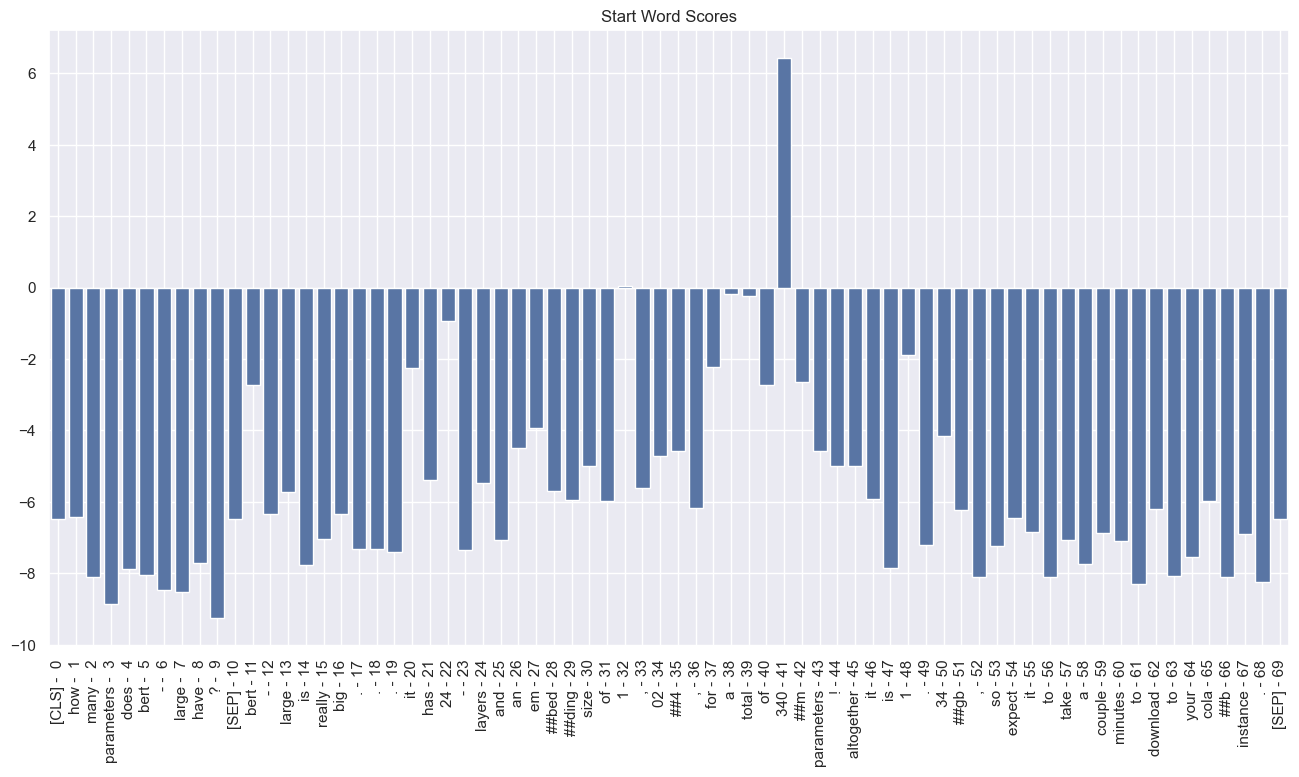

In [13]:
# Create a barplot showing the start word score for all of the tokens.
ax = sns.barplot(x=token_labels, y=s_scores, ci=None)

# Turn the xlabels vertical.
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")

# Turn on the vertical grid to help align words to scores.
ax.grid(True)

plt.title('Start Word Scores')

plt.show()

C:\Users\Viet\AppData\Local\Temp\ipykernel_15664\645875075.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x=token_labels, y=e_scores, ci=None)
C:\Users\Viet\AppData\Local\Temp\ipykernel_15664\645875075.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")


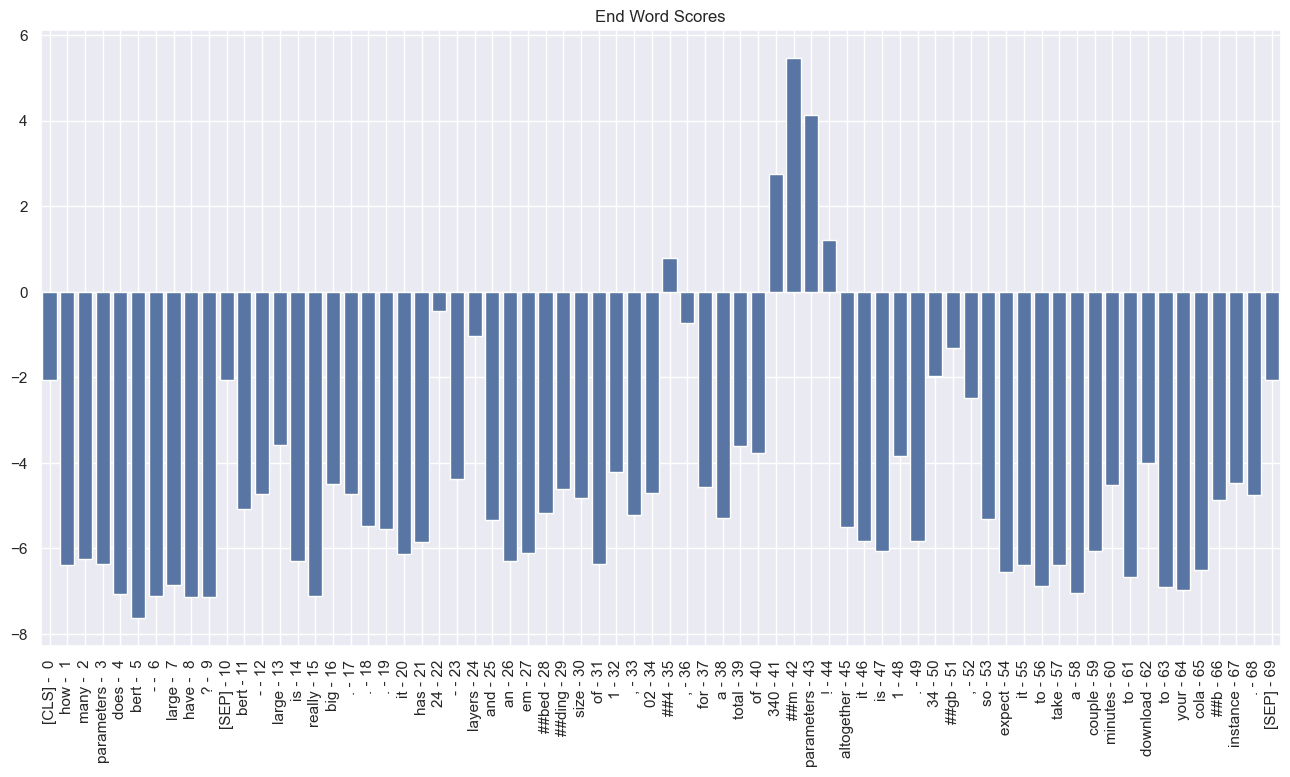

In [14]:
# Create a barplot showing the end word score for all of the tokens.
ax = sns.barplot(x=token_labels, y=e_scores, ci=None)

# Turn the xlabels vertical.
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")

# Turn on the vertical grid to help align words to scores.
ax.grid(True)

plt.title('End Word Scores')

plt.show()

In [15]:
import pandas as pd

# Store the tokens and scores in a DataFrame. 
# Each token will have two rows, one for its start score and one for its end
# score. The "marker" column will differentiate them. A little wacky, I know.
scores = []
for (i, token_label) in enumerate(token_labels):

    # Add the token's start score as one row.
    scores.append({'token_label': token_label, 
                   'score': s_scores[i],
                   'marker': 'start'})
    
    # Add  the token's end score as another row.
    scores.append({'token_label': token_label, 
                   'score': e_scores[i],
                   'marker': 'end'})
    
df = pd.DataFrame(scores)


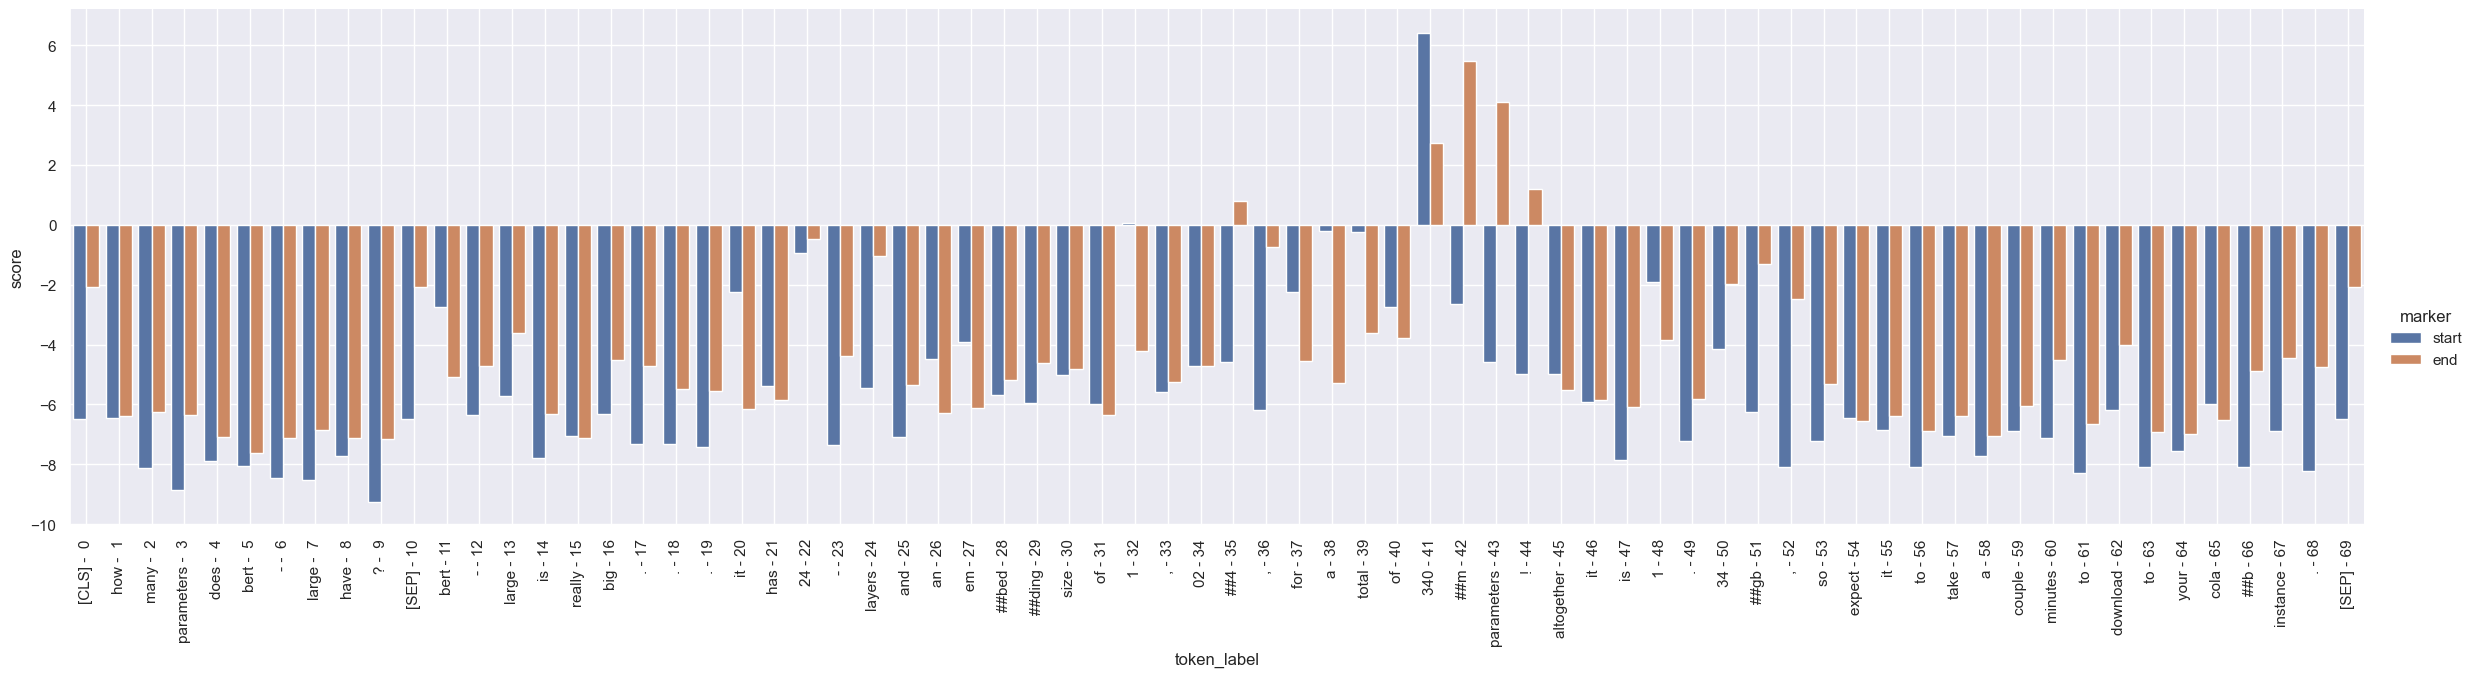

In [16]:
# Draw a grouped barplot to show start and end scores for each word.
# The "hue" parameter is where we tell it which datapoints belong to which
# of the two series.
g = sns.catplot(x="token_label", y="score", hue="marker", data=df,
                kind="bar", height=6, aspect=4)

# Turn the xlabels vertical.
g.set_xticklabels(g.ax.get_xticklabels(), rotation=90, ha="center")

# Turn on the vertical grid to help align words to scores.
g.ax.grid(True)


In [17]:
def answer_question(question, answer_text):
    '''
    Takes a `question` string and an `answer_text` string (which contains the
    answer), and identifies the words within the `answer_text` that are the
    answer. Prints them out.
    '''
    # ======== Tokenize ========
    # Apply the tokenizer to the input text, treating them as a text-pair.
    input_ids = tokenizer.encode(question, answer_text)

    # Report how long the input sequence is.
    print('Query has {:,} tokens.\n'.format(len(input_ids)))

    # ======== Set Segment IDs ========
    # Search the input_ids for the first instance of the `[SEP]` token.
    sep_index = input_ids.index(tokenizer.sep_token_id)

    # The number of segment A tokens includes the [SEP] token istelf.
    num_seg_a = sep_index + 1

    # The remainder are segment B.
    num_seg_b = len(input_ids) - num_seg_a

    # Construct the list of 0s and 1s.
    segment_ids = [0]*num_seg_a + [1]*num_seg_b

    # There should be a segment_id for every input token.
    assert len(segment_ids) == len(input_ids)

    # ======== Evaluate ========
    # Run our example through the model.
    outputs = model(torch.tensor([input_ids]), # The tokens representing our input text.
                    token_type_ids=torch.tensor([segment_ids]), # The segment IDs to differentiate question from answer_text
                    return_dict=True) 

    start_scores = outputs.start_logits
    end_scores = outputs.end_logits

    # ======== Reconstruct Answer ========
    # Find the tokens with the highest `start` and `end` scores.
    answer_start = torch.argmax(start_scores)
    answer_end = torch.argmax(end_scores)

    # Get the string versions of the input tokens.
    tokens = tokenizer.convert_ids_to_tokens(input_ids)

    # Start with the first token.
    answer = tokens[answer_start]

    # Select the remaining answer tokens and join them with whitespace.
    for i in range(answer_start + 1, answer_end + 1):
        
        # If it's a subword token, then recombine it with the previous token.
        if tokens[i][0:2] == '##':
            answer += tokens[i][2:]
        
        # Otherwise, add a space then the token.
        else:
            answer += ' ' + tokens[i]

    print('Answer: "' + answer + '"')

In [18]:
import textwrap

# Wrap text to 80 characters.
wrapper = textwrap.TextWrapper(width=80) 

bert_abstract = "We introduce a new language representation model called BERT, which stands for Bidirectional Encoder Representations from Transformers. Unlike recent language representation models (Peters et al., 2018a; Radford et al., 2018), BERT is designed to pretrain deep bidirectional representations from unlabeled text by jointly conditioning on both left and right context in all layers. As a result, the pre-trained BERT model can be finetuned with just one additional output layer to create state-of-the-art models for a wide range of tasks, such as question answering and language inference, without substantial taskspecific architecture modifications. BERT is conceptually simple and empirically powerful. It obtains new state-of-the-art results on eleven natural language processing tasks, including pushing the GLUE score to 80.5% (7.7% point absolute improvement), MultiNLI accuracy to 86.7% (4.6% absolute improvement), SQuAD v1.1 question answering Test F1 to 93.2 (1.5 point absolute improvement) and SQuAD v2.0 Test F1 to 83.1 (5.1 point absolute improvement)."

print(wrapper.fill(bert_abstract))

We introduce a new language representation model called BERT, which stands for
Bidirectional Encoder Representations from Transformers. Unlike recent language
representation models (Peters et al., 2018a; Radford et al., 2018), BERT is
designed to pretrain deep bidirectional representations from unlabeled text by
jointly conditioning on both left and right context in all layers. As a result,
the pre-trained BERT model can be finetuned with just one additional output
layer to create state-of-the-art models for a wide range of tasks, such as
question answering and language inference, without substantial taskspecific
architecture modifications. BERT is conceptually simple and empirically
powerful. It obtains new state-of-the-art results on eleven natural language
processing tasks, including pushing the GLUE score to 80.5% (7.7% point absolute
improvement), MultiNLI accuracy to 86.7% (4.6% absolute improvement), SQuAD v1.1
question answering Test F1 to 93.2 (1.5 point absolute improvement) 

In [19]:
question = "What does the 'B' in BERT stand for?"

answer_question(question, bert_abstract)

Query has 258 tokens.

Answer: "bidirectional encoder representations from transformers"


In [20]:
question = "What are some example applications of BERT?"

answer_question(question, bert_abstract)

Query has 255 tokens.

Answer: "question answering and language inference"
